# Optimizacion de tráfico entre 2 puntos mediante el algoritmo de Floyd-Warshall

## Integrantes:
* Martinez Rueda Daniel Aleandro
* Villamizar Villamizar Brayhan Giovanny
* Vargas Pinzon Kevin Steeve

## Introducción

Para solucionar el problema del tráfico excesivo y facilitar la navegación en la ciudad de Bucaramanga se propone usar el algoritmo de Floyd Warshall por sus beneficios al tratar con grafos fuertemente interconectados, puesto que su costo computacional solo depende de la cantidad de vértices de dicho grafo

## Modelado y Solución

Para la modelación del problema se usa la libreria igraph por su extensiva documentación y facilidad de uso.

In [8]:
import os
import sys
from igraph import *
import math
import pandas as pd

Tambien se plantea la configuracion base del programa.

In [9]:
# Configuracion de apariencia del grafo

graph_image_size = (600, 600)
graph_image_margin = 100

node_size = 45
node_color = 'tan'
node_shape = 'square'

graph_width = 5

edge_label_size = 10
edge_width = 3
edge_curveness = 0.05

Tambien se plantea la matriz de adyacencia a usar, en este caso se considera una que representen las calles entre 25 manzanas pertenecientes a una matriz 5x5, se consideran algunas calles de un solo sentido y casos en los que las calles no correspondan a una cuadrícula exacta.

In [10]:
 adjacency_matrix = [
        [0, 14, None, None, None, 23, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],  
        [25, 0, 11, None, None, None, 21, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],    
        [None, 19, 0, None, None, None, None, 22, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],  
        [None, None, 8, 0, 22, None, None, None, 15, 11, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],       
        [None, None, None, 13, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
        [7, None, None, None, None, 0, 13, None, None, None, 18, None, None, None, None, None, None, None, None, None, None, None, None, None, None],     
        [None, 7, 25, None, None, 16, 0, 14, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],       
        [None, None, 10, None, None, None, 8, 0, 16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],     
        [None, None, None, None, None, None, None, 16, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
        [None, None, None, None, 17, None, None, None, None, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
        [None, None, None, None, None, 25, None, None, None, None, 0, 5, None, None, None, 17, None, None, None, None, None, None, None, None, None],     
        [None, None, None, None, None, 26, None, None, None, None, 19, 0, 19, None, None, None, 13, None, None, None, None, None, None, None, None],
        [None, None, None, None, None, None, None, 6, None, None, None, 20, 0, 5, None, None, None, 27, None, None, None, None, None, None, None],
        [None, None, None, None, None, None, None, None, 10, None, None, None, None, 0, 6, None, None, None, 9, None, None, None, None, None, None],
        [None, None, None, None, None, None, None, None, None, 23, None, None, None, 14, 0, None, None, None, None, 6, None, None, None, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0, 15, None, None, None, None, None, None, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, 7, None, None, None, 16, 0, 7, None, None, 6, 27, None, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, 22, None, None, None, 7, 0, 22, None, None, None, 14, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, 5, None, None, None, 18, 0, 20, None, None, None, 5, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0, None, None, None, None, 18],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 9, None, None, None, None, 0, 10, None, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 27, None, None, None, 10, 0, 25, None, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 26, None, None, None, None, 0, 21, None],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 26, None, None, None, None, 0, 18],
        [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 17, 0],
    ]

# Se entiende a None como la ausencia de una conexion entre manzanas, el ciclo a continuacion cambia
# la matriz para que esto represente una distancia infinita

for row in adjacency_matrix:

    for j, column in enumerate(row):

        row[j] = row[j] if row[j] is not None else float('inf')

Con la matriz de adyacencia se puede crear el grafo a trabajar, primero se crean los vertices o nodos y luego las aristas

In [11]:
graph = Graph(directed=True)

matrix_size = len(adjacency_matrix)

node_positions = []

# Nodos
for i in range(matrix_size):

    graph.add_vertices(1)

    current_node = graph.vs[i]

    node_x = i % graph_width
    node_y = i // graph_width

    node_position = (node_x, node_y)
    node_positions.append(node_position)
    
    current_node['id'] = i
    current_node['label'] = f'{node_x} | {node_y}'

edgeless_graph = graph.copy()

edge_id = 0

# Aristas
for i in range(matrix_size):

    for j in range(matrix_size):

        value = adjacency_matrix[i][j]

        if value <= 0 or value >= float('inf'):
            continue
        
        graph.add_edge(i, j)
        current_edge = graph.es[edge_id]

        current_edge['label'] = str(value)
        current_edge['weight'] = value

        edge_id += 1

Una vez creado el grafo se muestra, para una visualizacion correcta se hacen los ajustes contenidos en graph_config

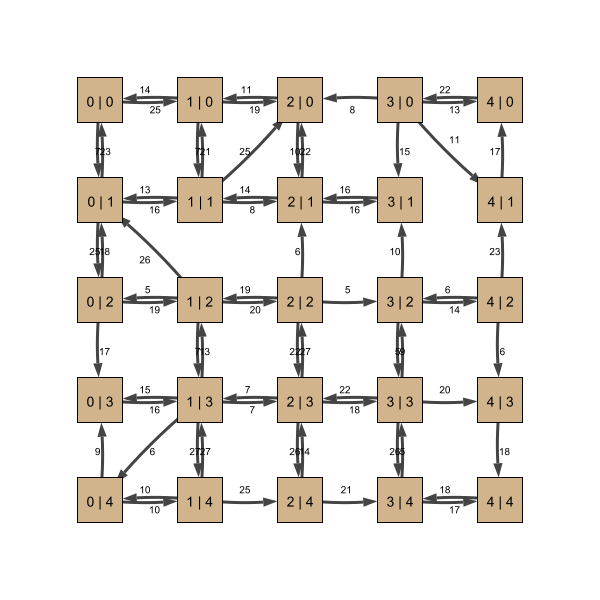

In [12]:
graph_layout = Layout(node_positions)

graph_config = dict()

graph_config['bbox'] = graph_image_size
graph_config['margin'] = graph_image_margin

graph_config['layout'] = graph_layout

graph_config['vertex_size'] = node_size
graph_config['vertex_color'] = node_color
graph_config['vertex_shape'] = node_shape


graph_config['edge_label_size'] = edge_label_size
graph_config['edge_width'] = edge_width
graph_config['edge_curved'] = edge_curveness

created_graph = graph.copy()

plot(created_graph, **graph_config)


A continuacion se define el algoritmo de Floyd-Warshall, la funcion responsable de este tomará la matriz de adyacencia procesada anteriormente y devolverá una tupla de 2 elementos con la matriz con las distancias mas cortas entre nodos y la matriz con la cual se obtendran los caminos mas cortos entre cualquier par de nodos, para la obtencion de este camino se definirá una funcion extra encargada de obtener el camino codificado en esta ultima matriz; para finalizar se define una tercera funcion que convierte este camino en un grafo que puede ser mostrado

In [13]:
def floyd_warshall(adjacency_matrix):

    current_matrix = adjacency_matrix

    node_amount = len(adjacency_matrix)

    path_matrix = [[None for n in range(node_amount)] for n in range(node_amount)]

    for i in range(node_amount):

        for j in range(node_amount):

            if adjacency_matrix[i][j] != float('inf'):
                path_matrix[i][j] = j


    for i in range(node_amount):

        for j in range(node_amount):

            for k in range(node_amount):

                old_weight = current_matrix[j][k]
                new_weight = current_matrix[j][i] + current_matrix[i][k]

                if  new_weight < old_weight:

                    current_matrix[j][k] = new_weight
                    path_matrix[j][k] = path_matrix[j][i]

    return (current_matrix, path_matrix)


def get_shortest_path(path_matrix, start, end):

    path = [start]
    current = start

    while current != end:

        current = path_matrix[current][end]
        path.append(current)

    return path

def path_to_graph(graph, path):

    output_graph = graph.copy()
    
    path_size = len(path)

    path_edges = set()

    for node_index in range(path_size-1):

        current_node = path[node_index]
        next_node = path[node_index+1]

        edge = output_graph.get_eid(current_node, next_node)

        path_edges.add(edge)
    
    all_edges = set(range(len(output_graph.es)))

    weak_edges = all_edges.difference(path_edges)

    for edge_id in weak_edges:

        edge = output_graph.es[edge_id]

        edge['color'] = 'light gray'
        edge['width'] = 1
        edge['label'] = ''

    return output_graph


In [14]:
distance_matrix, path_matrix = floyd_warshall(adjacency_matrix)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print(pd.DataFrame(distance_matrix))

      0    1    2    3    4    5    6   7   8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
0     0   14   25  129  116   23   35  47  63   99   41   46   65   70   76   58   59   66   79   82   65   75   80   84  100
1    25    0   11  143  130   37   21  33  49  113   55   60   79   84   90   72   73   80   93   96   79   89   94   98  114
2    44   19    0  152  139   46   30  22  38  122   64   69   88   93   99   81   82   89  102  105   88   98  103  107  123
3    52   27    8    0   22   54   38  30  15   11   72   77   96  101  107   89   90   97  110  113   96  106  111  115  131
4    65   40   21   13    0   67   51  43  28   24   85   90  109  114  120  102  103  110  123  126  109  119  124  128  144
5     7   20   31  106   93    0   13  27  43   76   18   23   42   47   53   35   36   43   56   59   42   52   57   61   77
6    23    7   18  122  109   16    0  14  30   92   34   39   58   63   69   51   52   59   72   75   58   68   73   

A continuación se demuestran las capacidades del algoritmo, a partir de la matriz de caminos obtenida se pueden obtener los caminos mas cortos entre cualquier par de nodos.

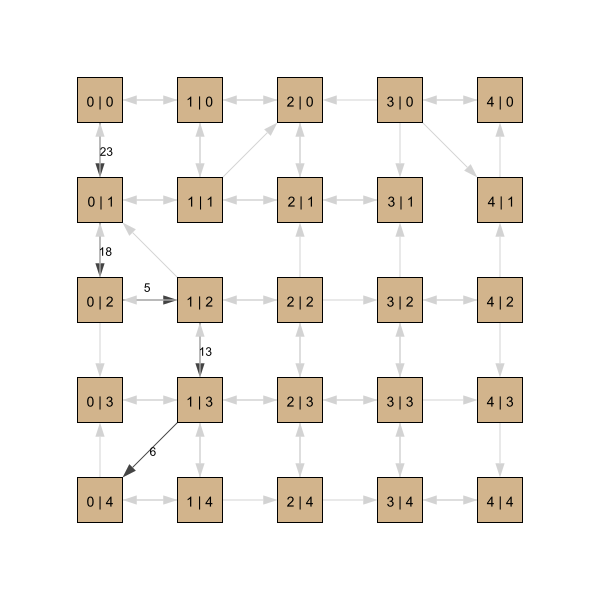

In [15]:
path_graph_config = dict(graph_config)

del path_graph_config['edge_label_size']
del path_graph_config['edge_width']

path_graph_config['edge_curved'] = 0

path = get_shortest_path(path_matrix, 0, 20)

path_to_graph(graph, path)

path_graph = path_to_graph(graph, path)

plot(path_graph, **path_graph_config)

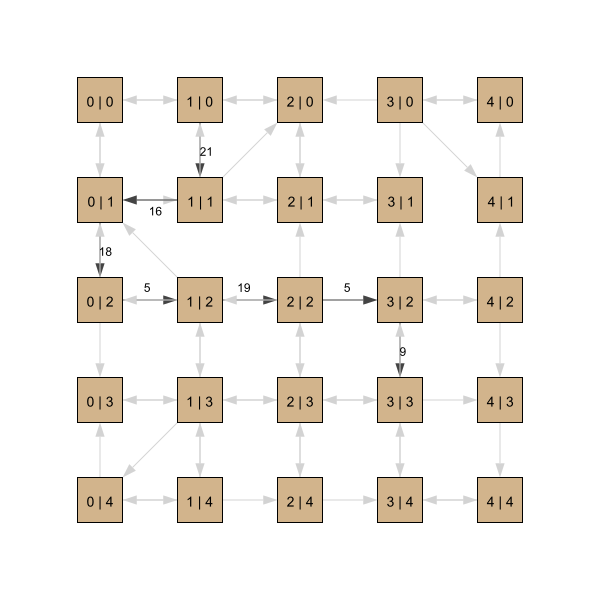

In [16]:
path = get_shortest_path(path_matrix, 1, 18)

path_graph_2 = path_to_graph(graph, path)

plot(path_graph_2, **path_graph_config)